<a href="https://colab.research.google.com/github/HaukeGS/AMLG-Project/blob/main/Assignment3_Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.0 Introduction

## Imports and Initializations

In [46]:
# imports

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [47]:
CLASS_LABEL_MAP = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is: {device}\n")

Device is: cuda



In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
# Hyperparameters

BATCH_SIZE = 16
LEARNING_RATE = 0.001
EPOCHS = 10
IMAGE_SIZE = 64
FEATURE_MAPS = 64
IMAGE_CHANNELS = 3

## Data Preprocessing

In [51]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

training_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

dataloader_train = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True, num_workers=2)
dataloader_test = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [52]:
# filter the dataset for cats and dogs

filtered_indices = [i for i, (_, label) in enumerate(training_set) if label in [3, 5]]
filtered_dataset = torch.utils.data.Subset(training_set, filtered_indices)
dataloader_catsNdogs_train = torch.utils.data.DataLoader(filtered_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

filtered_indices = [i for i, (_, label) in enumerate(test_set) if label in [3, 5]]
filtered_dataset = torch.utils.data.Subset(test_set, filtered_indices)
dataloader_catsNdogs_test = torch.utils.data.DataLoader(filtered_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

In [53]:
# filter the dataset for everything else

filtered_indices = [i for i, (_, label) in enumerate(training_set) if label not in [3, 5]]
filtered_dataset = torch.utils.data.Subset(training_set, filtered_indices)
dataloader_everythingElse_train = torch.utils.data.DataLoader(filtered_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

filtered_indices = [i for i, (_, label) in enumerate(test_set) if label not in [3, 5]]
filtered_dataset = torch.utils.data.Subset(test_set, filtered_indices)
dataloader_everythingElse_test = torch.utils.data.DataLoader(filtered_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [54]:
# verify

for images, labels in dataloader_catsNdogs_train:
    if labels.shape[0] != BATCH_SIZE:
        print("uneven amount of images in batch")
    for label in labels:
        if label not in [3, 5]:
            print("wrong label")

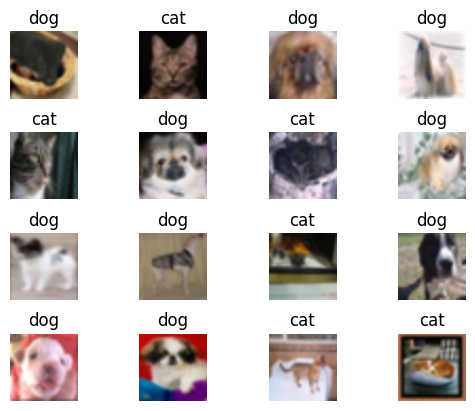

In [55]:
for images, labels in dataloader_catsNdogs_train:
    fig, axes = plt.subplots(4, 4)
    for i in range(4):
        for j in range(4):
            image = images[i * 4 + j]
            label = labels[i * 4 + j]
            axes[i, j].imshow(image.permute(1, 2, 0))
            axes[i, j].set_title(CLASS_LABEL_MAP.get(label.item()))
            axes[i, j].axis('off')
    fig.subplots_adjust(hspace=0.5)
    plt.show()
    break

# 1.1 CNN

In [56]:
dimension = IMAGE_SIZE

layers = [
    {'in_channels': IMAGE_CHANNELS, 'out_channels': int(FEATURE_MAPS/2), 'kernel_size': 4, 'stride': 2, 'padding': 1},
    {'in_channels': FEATURE_MAPS/2, 'out_channels': FEATURE_MAPS, 'kernel_size': 4, 'stride': 2, 'padding': 1},
    {'in_channels': FEATURE_MAPS, 'out_channels': FEATURE_MAPS*2, 'kernel_size': 4, 'stride': 2, 'padding': 1},
    {'in_channels': FEATURE_MAPS*2, 'out_channels': FEATURE_MAPS*4, 'kernel_size': 4, 'stride': 2, 'padding': 1},
    {'in_channels': FEATURE_MAPS*4, 'out_channels': 1, 'kernel_size': 4, 'stride': 1, 'padding': 0},
]

def calculate_output_dimension(layer):
    return int((dimension + 2 * layer.get('padding', 0) - layer.get('dilation', 1) * (layer.get('kernel_size', 1) - 1) - 1) / layer.get('stride', 1)) + 1

print(f"Input dimensions: {IMAGE_CHANNELS} x {dimension} x {dimension}")
for i, layer in enumerate(layers):
    dimension = calculate_output_dimension(layer)
    print(f"Output dimensions after layer {i}: {layer.get('out_channels')} x {dimension} x {dimension}")

Input dimensions: 3 x 64 x 64
Output dimensions after layer 0: 32 x 32 x 32
Output dimensions after layer 1: 64 x 16 x 16
Output dimensions after layer 2: 128 x 8 x 8
Output dimensions after layer 3: 256 x 4 x 4
Output dimensions after layer 4: 1 x 1 x 1


In [57]:
# CNN

class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layers = torch.nn.Sequential(
            # input size is 1 x 64 x 64
            nn.Conv2d(in_channels=IMAGE_CHANNELS, out_channels=int(FEATURE_MAPS / 2), kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),
            # state size 8 x 32 x 32
            nn.Conv2d(in_channels=int(FEATURE_MAPS / 2), out_channels=FEATURE_MAPS, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(FEATURE_MAPS),
            nn.LeakyReLU(0.2),
            # state size FEATURE_MAPS x 12 x 12
            nn.Conv2d(in_channels=FEATURE_MAPS, out_channels=FEATURE_MAPS * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(FEATURE_MAPS * 2),
            nn.LeakyReLU(0.2),
            # state size FEATURE_MAPS x 12 x 12
            nn.Conv2d(in_channels=FEATURE_MAPS * 2, out_channels=FEATURE_MAPS * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(FEATURE_MAPS * 4),
            nn.LeakyReLU(0.2),
            # state size (FEATURE_MAPS * 2) x 4 x 4
            nn.Conv2d(in_channels=FEATURE_MAPS * 4, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

In [58]:
# training loop

def train_cnn(dataloader, model, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        dataloader = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for i, (images, labels) in enumerate(dataloader):
            mapped_labels = []
            for label in labels:
                mapped_labels.append(1.0 if label == 3 else 0.0)
            labels = torch.tensor(mapped_labels)
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images).squeeze()
            # print(f"outputs: {outputs.shape}")
            # print(f"labels: {labels.shape}")
            # print(f"outputs: {outputs}")
            # print(f"labels: {labels}")
            # print(f"outputs dtype: {outputs.dtype}")
            # print(f"labels dtype: {labels.dtype}")
            # labels = labels.float()
            # print(f"labels dtype: {labels.dtype}")
            # break

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            dataloader.set_postfix({'loss': running_loss / (i+1)})

In [59]:
# directory paths to google drive for model saving and retrieving

directory_path = '/content/drive/MyDrive/google_colab/A3T11'

cnn_model_path = os.path.join(directory_path, 'cnn_model.pth')

In [71]:
# Initialize the model

LOAD_FROM_DRIVE = True

cnn = CNN().to(device)

if LOAD_FROM_DRIVE:
    try:
        cnn.load_state_dict(torch.load(cnn_model_path, weights_only=True))
        print("Model loaded from drive")
    except Exception as e:
        print(f"Error loading model from drive: {e}")

# set up loss function and optimizer

criterion = nn.BCELoss()
optimizer = optim.Adam(cnn.parameters(), lr=LEARNING_RATE)

Model loaded from drive


In [61]:
# start training loop
if not LOAD_FROM_DRIVE:
    train_cnn(
        dataloader=dataloader_catsNdogs_train,
        model=cnn,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=EPOCHS
    )

In [62]:
# save to drive

SAVE_TO_DRIVE = True

if SAVE_TO_DRIVE:
    try:
        os.makedirs(directory_path)
    except FileExistsError:
        pass

    torch.save(cnn.state_dict(), cnn_model_path)
    print("Model saved to drive")

Model saved to drive


In [69]:
# evaluate the model
# ToDo: Calculate Accuracy and F1-Score for the model

def evaluate(dataloader, model):
    model.eval()
    model.to('cpu')
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images).squeeze()
            print(f"output: {outputs}")
            break

In [70]:
evaluate(dataloader_catsNdogs_test, cnn)

output: tensor([0.9938, 0.9384, 0.0197, 0.0299, 0.0257, 0.0860, 0.1365, 0.0488, 0.8035,
        0.6772, 0.8979, 0.2060, 0.6621, 0.3481, 0.9080, 0.7922])


# 1.2 Pre-training

# 1.3 Fine-tuning